In [1]:
# Development mode: automatic reloading of modules
%load_ext autoreload
%autoreload 2

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-09-08 18:00:51.271429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Current directory:  /Users/ywu/InSync/2019_Computations/ML-Snippets/DeepSHAP/1_multiple_references/NHANES_background_distribution
Append directory:  /Users/ywu/InSync/2019_Computations/ML-Snippets/DeepSHAP
DPATH directory:  /Users/ywu/InSync/2019_Computations/ML-Snippets/DeepSHAP/NHANES/data
112/112 [==============================] - 0s 938us/step
Test ROC: 0.8738151389314179


Trying to unpickle estimator KMeans from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


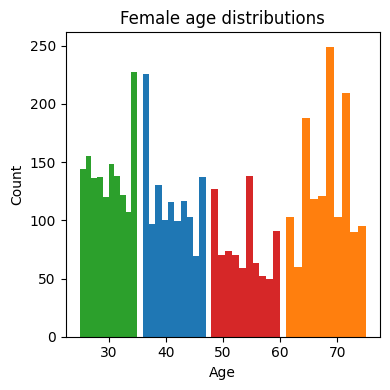

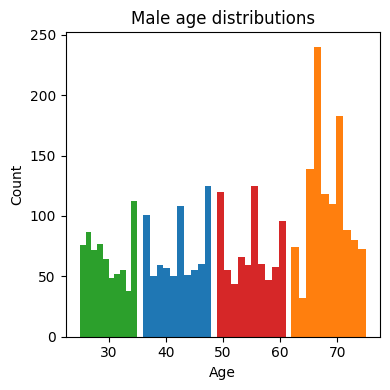

In [2]:
from util import get_clusters, get_raw_trainx
from model import nhanes_mlp
from deepshap.data import load_nhanes, get_nhanes_feat_names
import xgboost
import shap
import os
import scipy
import sklearn
import sys
import pandas as pd
import numpy as np
import keras
import pickle

# current working directory
current_directory = os.getcwd()
print("Current directory: ", current_directory)

# print absolute paths
append_path = ("../..")
sys.path.append(append_path)
print("Append directory: ", os.path.abspath(append_path))

# Load data
trainx, trainy, _, _, testx, testy = load_nhanes()
feat_names = get_nhanes_feat_names()

# Load model
model = nhanes_mlp()

# Get raw data and form clusters
raw_trainx = get_raw_trainx()
clusters, raw_clusters = get_clusters(trainx, raw_trainx)

In [3]:
print(len(clusters))
raw_clusters[2]

8


,sex_isFemale,age,physical_activity,serum_albumin,alkaline_phosphatase,alkaline_phosphatase_isUnacceptable,alkaline_phosphatase_isTestnotdone,SGOT,SGOT_isUnacceptable,SGOT_isTestnotdone,...,urine_hematest_isBlankbutapplicable,sedimentation_rate,sedimentation_rate_isBlankbutapplicable,uric_acid,uric_acid_isUnacceptable,uric_acid_isTestnotdone,systolic_blood_pressure,pulse_pressure,weight,height
20809,False,74,2,NaN,60.0,False,False,2.09,False,False,...,False,NaN,False,4.3,False,False,184.0,90.0,46.72,157.5
27,False,72,2,4.1,NaN,False,False,NaN,False,False,...,False,21.0,False,NaN,False,False,220.0,104.0,85.62,170.2
61,False,74,4,4.5,NaN,False,False,NaN,False,False,...,False,20.0,False,NaN,False,False,126.0,52.0,79.61,175.1
80,False,71,2,3.2,NaN,False,False,NaN,False,False,...,False,38.0,False,NaN,False,False,110.0,28.0,56.81,150.3
85,False,66,4,3.9,NaN,False,False,NaN,False,False,...,False,28.0,False,NaN,False,False,166.0,70.0,86.52,164.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24951,False,67,3,NaN,45.0,False,False,2.26,False,False,...,False,NaN,False,4.9,False,False,150.0,60.0,90.15,188.7
24958,False,72,2,NaN,61.0,False,False,2.37,False,False,...,False,NaN,False,4.3,False,False,150.0,50.0,77.34,182.6
24979,False,67,2,NaN,60.0,False,False,2.44,False,False,...,False,NaN,False,6.0,False,False,160.0,60.0,84.59,179.6
24991,False,73,4,NaN,73.0,False,False,2.95,False,False,...,False,NaN,False,5.0,False,False,160.0,80.0,47.97,162.4


In [4]:
attr_method = "deepshap"
n_clusters = len(clusters)

#### Save clustered backgrounds ####
ATTR_PATH = "attr/{}_kmeans{}_clusbg_attr_lst.p".format(
    attr_method, n_clusters)

# Get explanations using clusters as backgrounds
if not os.path.exists(ATTR_PATH):

    # Get attributions for each cluster using that cluster as bg
    clus_attr_lst = []
    for clusterx in clusters:
        expl = shap.DeepExplainer(model, clusterx)
        attr = expl.shap_values(clusterx)[0]
        clus_attr_lst.append(attr)
    pickle.dump(clus_attr_lst, open(ATTR_PATH, "wb"))
else:
    clus_attr_lst = pickle.load(open(ATTR_PATH, "rb"))

#### Save random backgrounds ####
ATTR_PATH = "attr/{}_kmeans{}_randbg_attr_lst.p".format(
    attr_method, n_clusters)

# Get explanations using random backgrounds
if not os.path.exists(ATTR_PATH):
    rand_attr_lst = []

    # Randomly sample background
    np.random.seed(10)
    n = trainx.shape[0]
    ref_size = 1000
    refe_inds = np.random.choice(n, ref_size, replace=False)
    refe = trainx[refe_inds]

    # Get attributions for each cluster
    for clusterx in clusters:
        expl = shap.DeepExplainer(model, refe)
        attr = expl.shap_values(clusterx)[0]
        rand_attr_lst.append(attr)
    pickle.dump(rand_attr_lst, open(ATTR_PATH, "wb"))
else:
    rand_attr_lst = pickle.load(open(ATTR_PATH, "rb"))

####################
### Gender: Male, Age: [36, 48] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


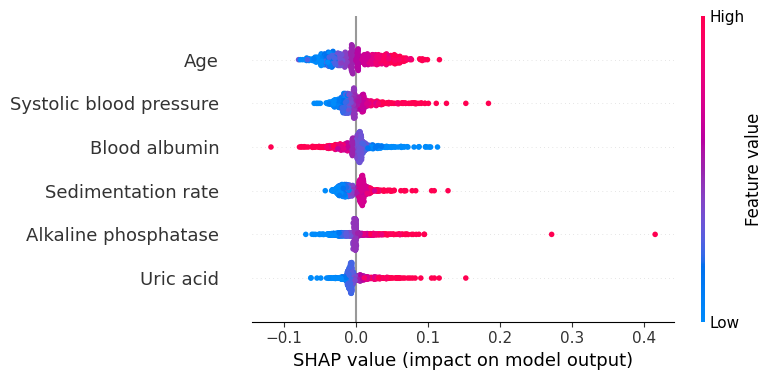

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


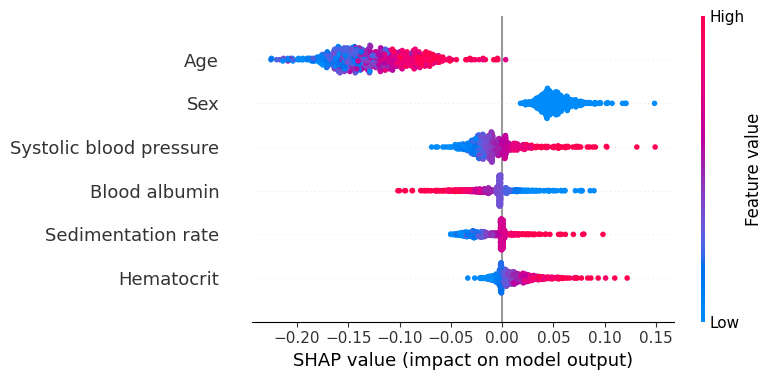

####################
### Gender: Female, Age: [36, 47] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


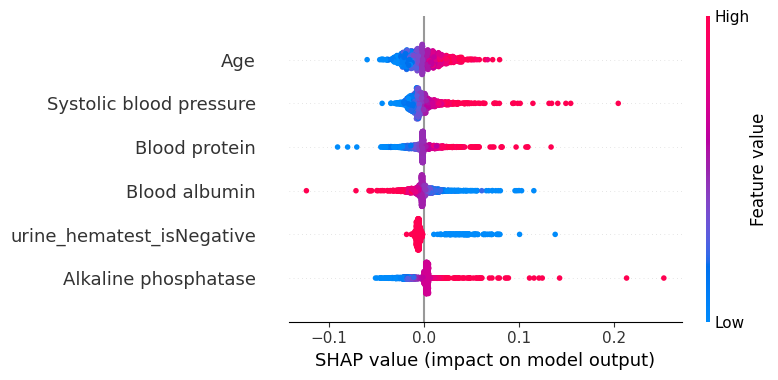

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


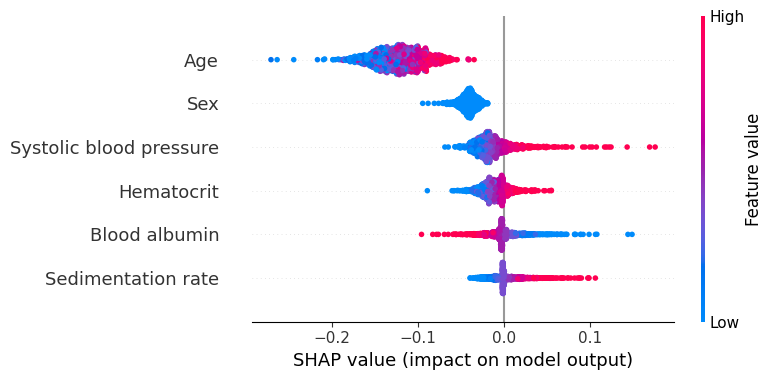

####################
### Gender: Male, Age: [62, 75] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


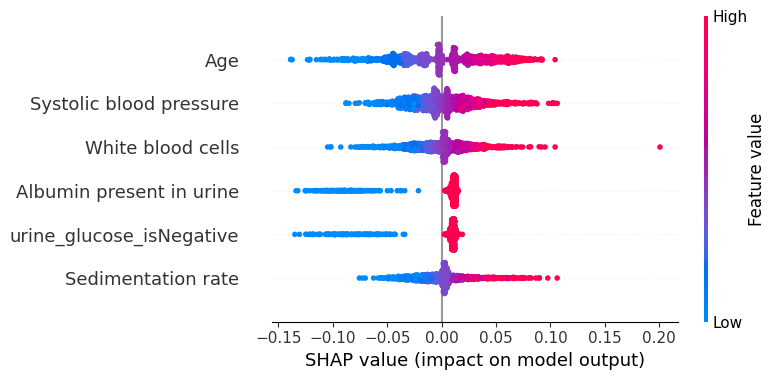

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


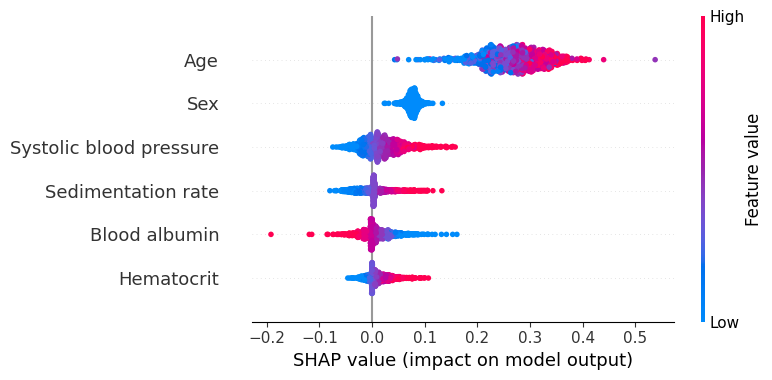

####################
### Gender: Female, Age: [61, 75] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


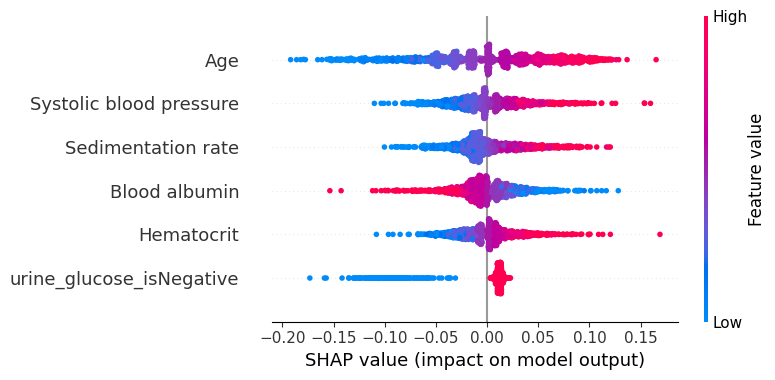

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


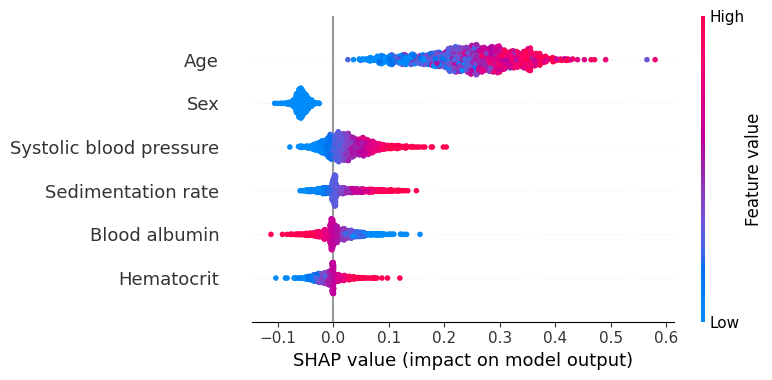

####################
### Gender: Male, Age: [25, 35] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


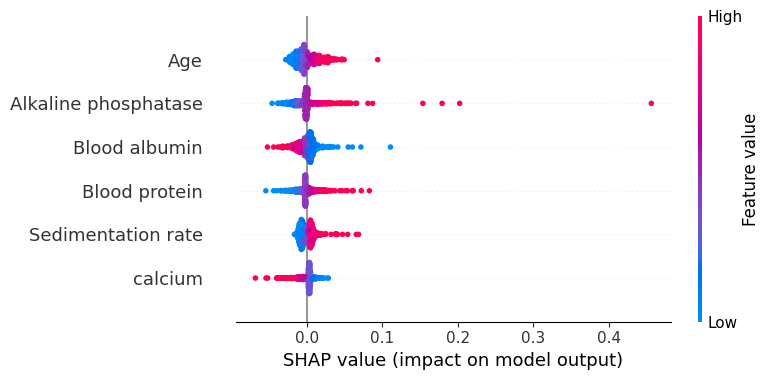

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


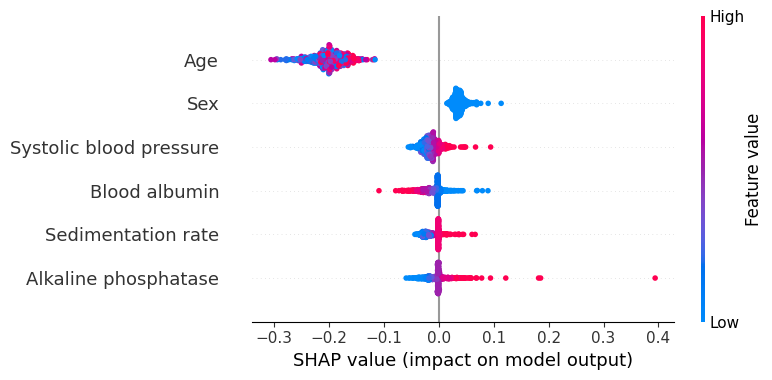

####################
### Gender: Female, Age: [25, 35] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


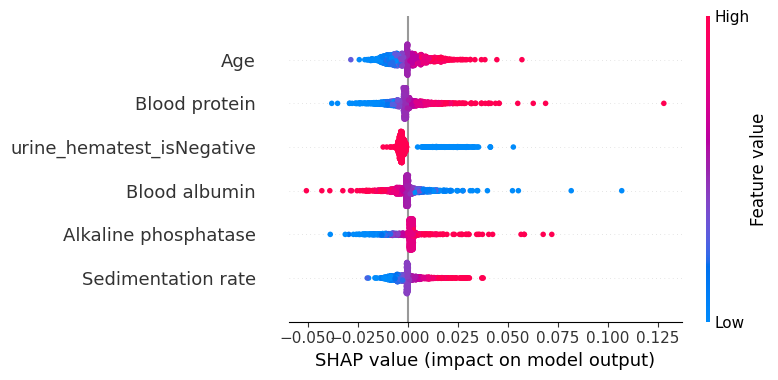

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


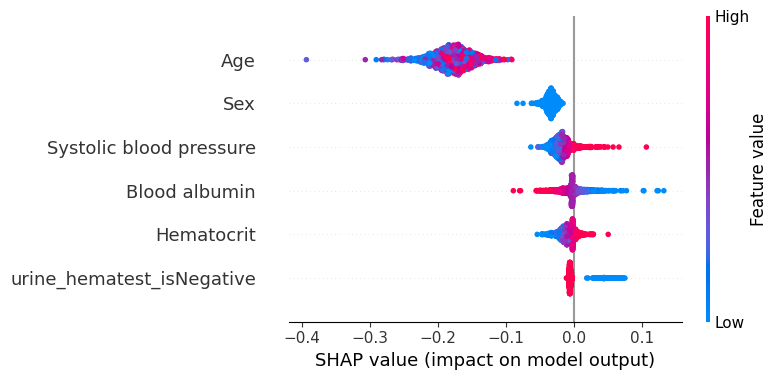

####################
### Gender: Male, Age: [49, 61] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


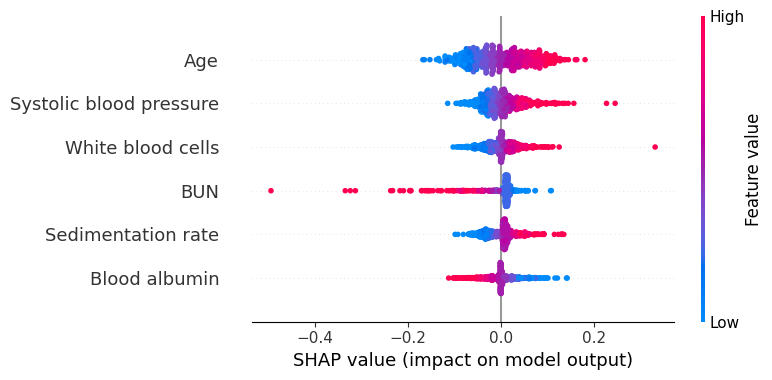

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


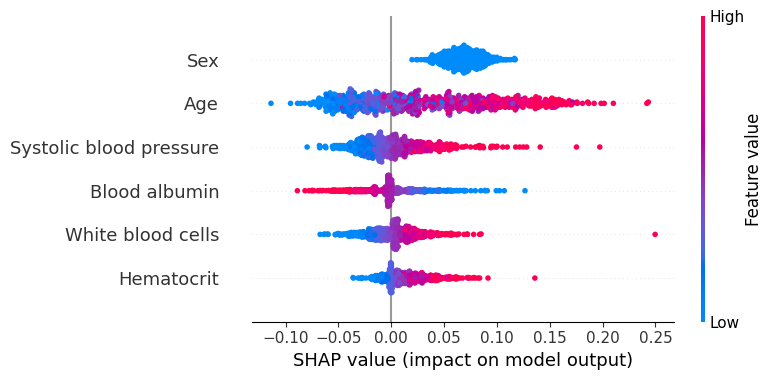

####################
### Gender: Female, Age: [48, 60] ###
####################
## Cluster Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


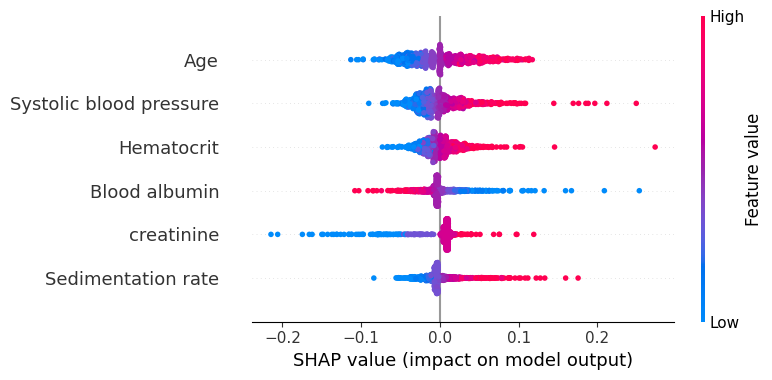

## Random Background ##


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


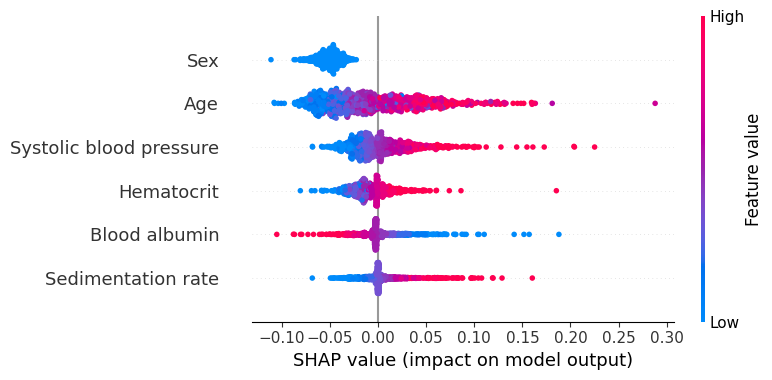

In [6]:
from util import cluster_summary_plots
cluster_summary_plots(clus_attr_lst, rand_attr_lst,
                      clusters, raw_clusters, feat_names)